# Fire Detection in Images

**Description about the dataset:**

Data was collected to train a model to distinguish between the images that contain fire (fire images) and regular images (non-fire images). Data is divided into 2 folders, fireimages folder contains 755 outdoor-fire images some of them contains heavy smoke, the other one is non-fireimages which contain 244 nature images (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).

**Objective: To create a classification model that can detect fire in images**

**Models used: Sequential CNN from scratch, Pretrained Xception with modifications**

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

**Let's first create a dataframe that contains the path to each picture and its corresponding label (fire or non fire).**

**Reading Paths**

In [2]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('/kaggle/input/fire-dataset/fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/kaggle/input/fire-dataset/fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
1,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
2,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
4,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
5,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire
6,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
7,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
8,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire
9,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire


**Great! the dataset has been created. Let's see how well the data is shuffled.**

In [3]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

**The shuffling has taken place well.**

**Let's visualize the countplot of the data**

In [4]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)


**Non fire label has less number of images. The dataset is imbalanced**

## Visualizing the images with fire

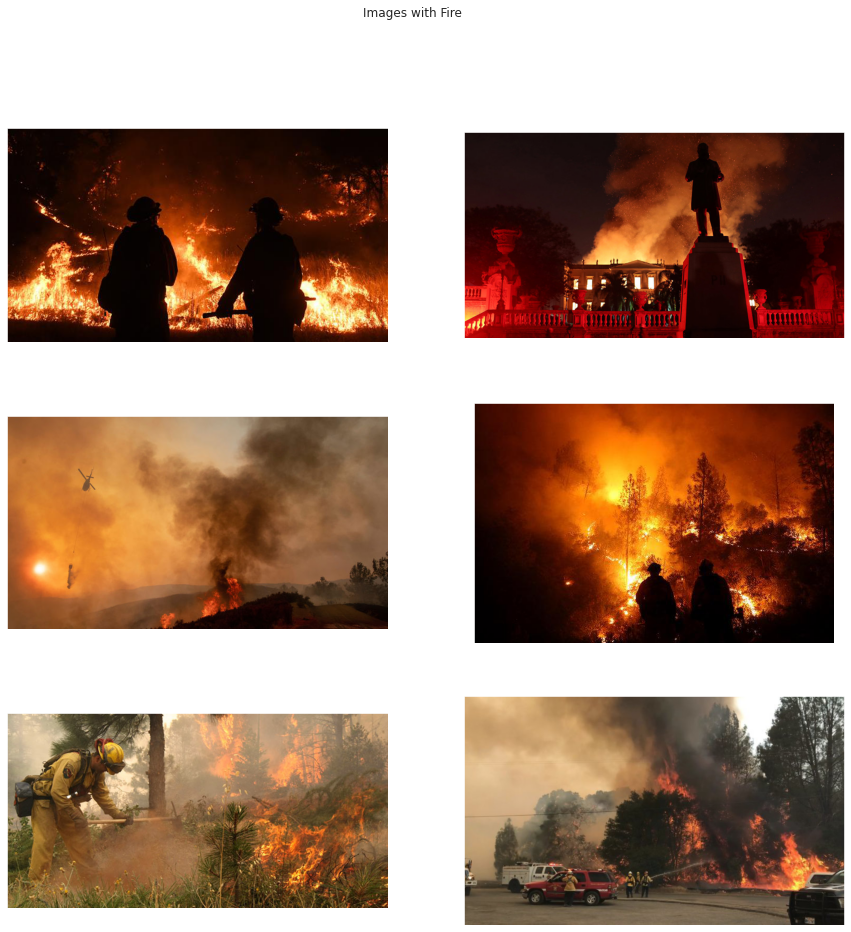

In [5]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

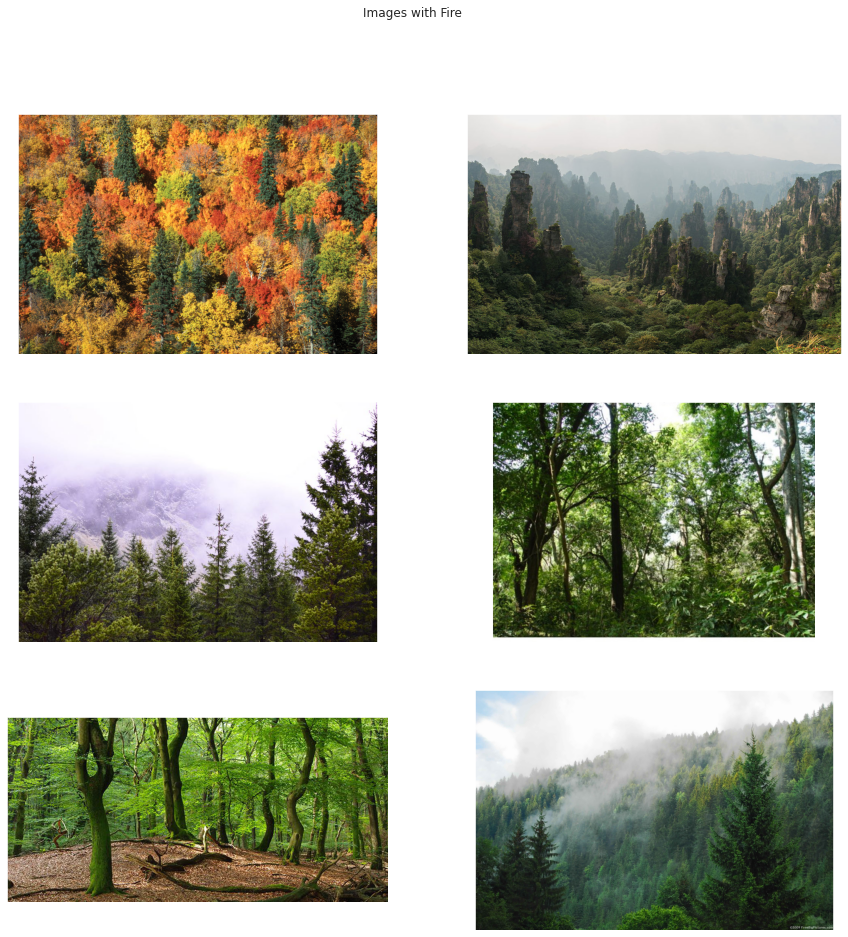

In [6]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

**As you can see, the sizes of the images are different. Let's visualize the distribution of their shapes**

In [7]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,983,1500
1,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,320,620
2,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,1287,2048
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,fire,414,992
4,/kaggle/input/fire-dataset/fire_dataset/non_fi...,non_fire,650,712


## Visualizing Shape Distribution

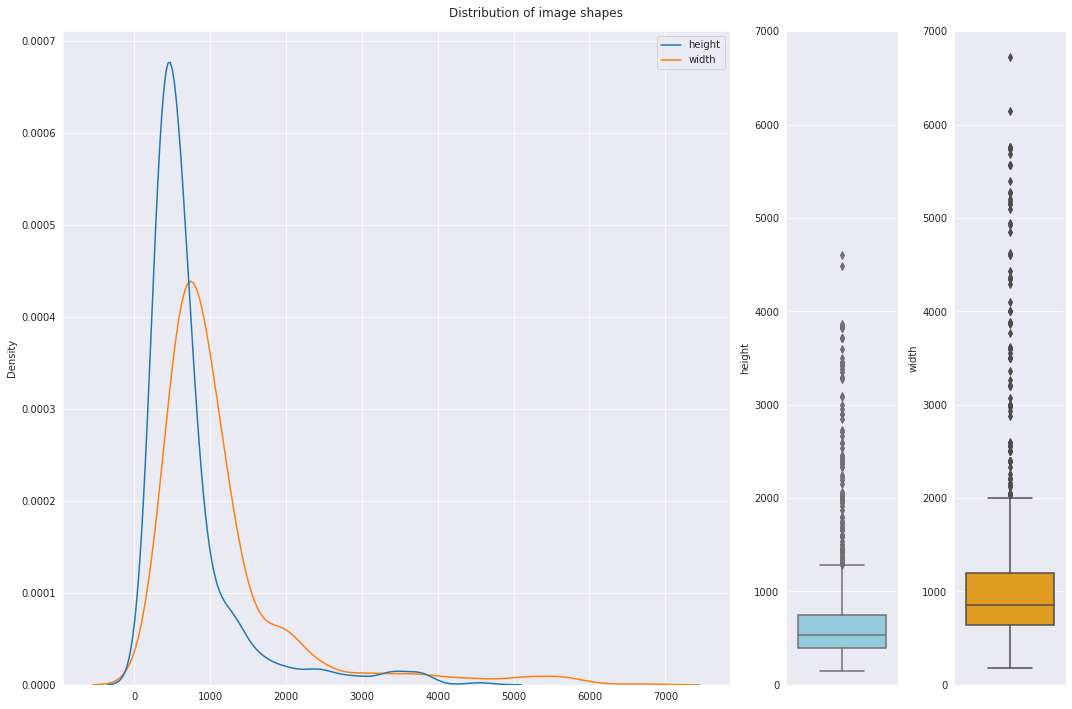

In [8]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

**The height and width of images vary too much. We have to reshape them to a fixed shape before training**

## Image Generation or Augmentation

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

**Creating the training and test generator**

**We will use the flow_from_dataframe method of the ImageDataGenerator class. It will take the path of the images from the dataframe along with their labels. We construct two generators, one for training and the other for validation.**

**Note: Our labels are strings 'fire ' and 'non_fire'. Image generator will automatically encode them to integer labels.**

In [41]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


#### Class indices assigned by the Image generator

In [42]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


**Hence an image predicted 0 will contain fire and 1 won't.**

## Visualizing the generated images in training set

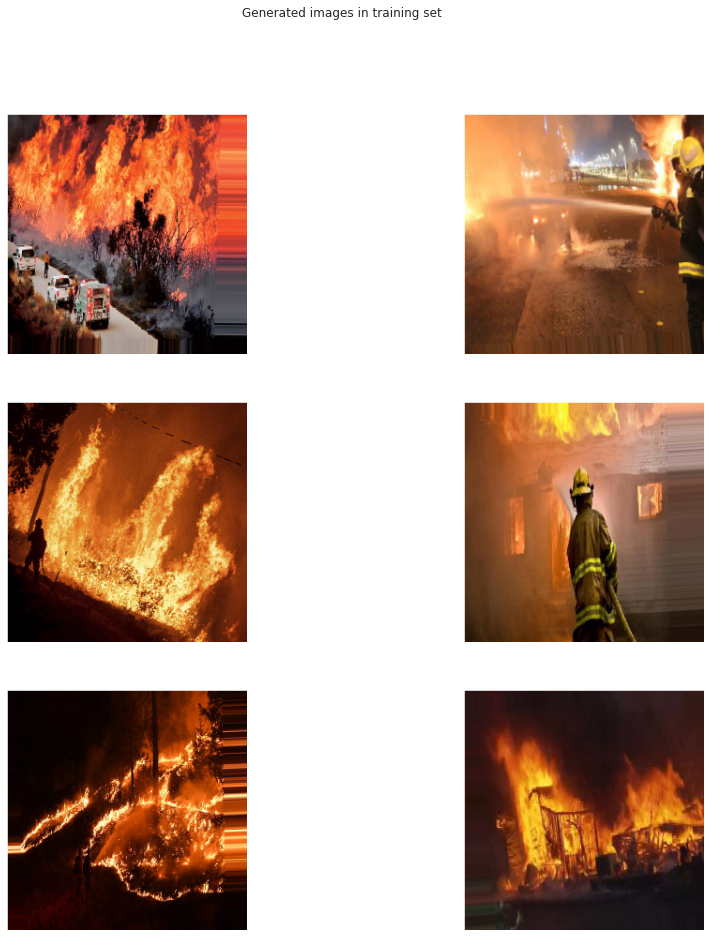

In [43]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Creating the model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [47]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

**We increase the number of filters as we add more layers because initially there will be a lot of noise present in the input and we only need to capture the important information. Later as we progress through the layers, the feature maps become nuanced and we try to capture them with more filters**  

### Model Summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0

**Compiling the model**

In [48]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [49]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

**Defining Callbacks**


In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [52]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

### Model Fitting

In [53]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
25/25 [==============================] - 73s 3s/step - loss: 0.5228 - accuracy: 0.8011 - recall_2: 0.3723 - auc_2: 0.7676 - val_loss: 0.3373 - val_accuracy: 0.8744 - val_recall_2: 0.5098 - val_auc_2: 0.9660
Epoch 2/15
25/25 [==============================] - 69s 3s/step - loss: 0.2033 - accuracy: 0.9356 - recall_2: 0.7720 - auc_2: 0.9609 - val_loss: 0.1213 - val_accuracy: 0.9397 - val_recall_2: 0.8235 - val_auc_2: 0.9806
Epoch 3/15
25/25 [==============================] - 69s 3s/step - loss: 0.1296 - accuracy: 0.9590 - recall_2: 0.8747 - auc_2: 0.9814 - val_loss: 0.1084 - val_accuracy: 0.9598 - val_recall_2: 0.9216 - val_auc_2: 0.9898
Epoch 4/15
25/25 [==============================] - 69s 3s/step - loss: 0.1095 - accuracy: 0.9510 - recall_2: 0.8771 - auc_2: 0.9905 - val_loss: 0.1360 - val_accuracy: 0.9497 - val_recall_2: 0.8627 - val_auc_2: 0.9902
Epoch 5/15
25/25 [==============================] - 69s 3s/step - loss: 0.1280 - accuracy: 0.9516 - recall_2: 0.8843 - auc_2: 0.

### Model Evaluation

**Plotting metrics**

In [54]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [55]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 11s 1s/step - loss: 0.0881 - accuracy: 0.9749 - recall_2: 0.9412 - auc_2: 0.9938
loss: 0.09
accuracy: 0.97
recall_2: 0.94
auc_2: 0.99


## Model creation by transfer learning

In [62]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [80]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83689472/83683744 [==============================] - 3s 0us/step


**Compiling the model**

In [81]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

**Fitting the model**

In [82]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
25/25 [==============================] - 172s 7s/step - loss: 4.4334 - accuracy: 0.7457 - recall_3: 0.5597 - auc_3: 0.7251 - val_loss: 0.2032 - val_accuracy: 0.9196 - val_recall_3: 0.9804 - val_auc_3: 0.9899
Epoch 2/15
25/25 [==============================] - 165s 7s/step - loss: 0.2174 - accuracy: 0.9397 - recall_3: 0.9470 - auc_3: 0.9735 - val_loss: 0.0993 - val_accuracy: 0.9648 - val_recall_3: 1.0000 - val_auc_3: 0.9943
Epoch 3/15
25/25 [==============================] - 166s 7s/step - loss: 0.0999 - accuracy: 0.9658 - recall_3: 0.9664 - auc_3: 0.9934 - val_loss: 0.1136 - val_accuracy: 0.9598 - val_recall_3: 0.9804 - val_auc_3: 0.9860
Epoch 4/15
25/25 [==============================] - 166s 7s/step - loss: 0.0567 - accuracy: 0.9860 - recall_3: 0.9737 - auc_3: 0.9969 - val_loss: 0.1223 - val_accuracy: 0.9648 - val_recall_3: 0.8627 - val_auc_3: 0.9852
Epoch 5/15
25/25 [==============================] - 166s 7s/step - loss: 0.0630 - accuracy: 0.9835 - recall_3: 0.9693 - auc_

### Model Evaluation

In [68]:
px.line(history,title='Metrics Plot')

In [83]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 12s 2s/step - loss: 0.0851 - accuracy: 0.9598 - recall_2: 0.9020 - auc_2: 0.9947
loss: 0.09
accuracy: 0.96
recall_2: 0.90
auc_2: 0.99


## Example Prediction

**Let's use an image of the apartment complex in Texas that caught fire in February 2021.**

News link : https://www.nytimes.com/2021/02/19/us/san-antonio-fire-hydrants-water.html

In [84]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   164k      0 --:--:-- --:--:-- --:--:--  163k


**Printing the image**

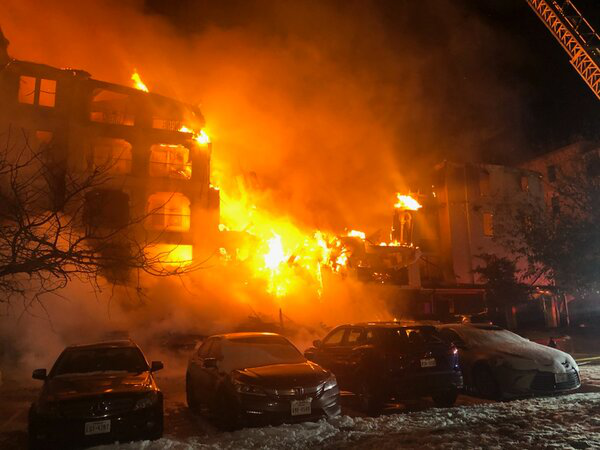

In [85]:
#loading the image
img = image.load_img('predict.jpg')
img

**Resizing the image and expanding its dimension to include the batch size - 1**

In [86]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


**Prediction**

In [87]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  0 and the predicted label is: fire


# Thank You